In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [4]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[1.7909],
         [1.3739]]),
 tensor([[1.0000e+00, 1.7909e+00, 1.6037e+00, 9.5736e-01, 4.2864e-01, 1.5353e-01,
          4.5827e-02, 1.1725e-02, 2.6247e-03, 5.2229e-04, 9.3538e-05, 1.5229e-05,
          2.2728e-06, 3.1311e-07, 4.0054e-08, 4.7822e-09, 5.3528e-10, 5.6391e-11,
          5.6106e-12, 5.2885e-13],
         [1.0000e+00, 1.3739e+00, 9.4386e-01, 4.3227e-01, 1.4848e-01, 4.0801e-02,
          9.3429e-03, 1.8338e-03, 3.1494e-04, 4.8080e-05, 6.6059e-06, 8.2510e-07,
          9.4470e-08, 9.9844e-09, 9.7986e-10, 8.9751e-11, 7.7071e-12, 6.2289e-13,
          4.7545e-14, 3.4381e-15]]),
 tensor([7.0177, 5.9537]))

In [5]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.994522   1.2025458 -3.405939   5.5960536]]


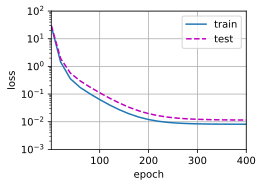

In [7]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.824093  4.2845716]]


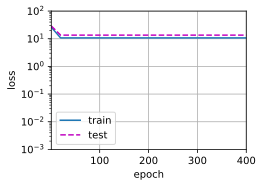

In [8]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.974606    1.2677963  -3.3331332   5.2315984  -0.1772565   1.1160975
   0.2579633   0.15951464 -0.02946316  0.02132626  0.06907798  0.12347385
   0.02254442  0.16529319  0.07259485 -0.0292926  -0.06800836  0.17820838
   0.12150329  0.11476985]]


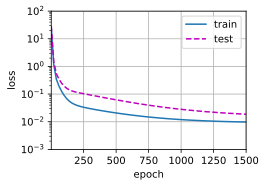

In [9]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)